Re-implementing NeRF paper in a single notebook.

In [100]:
import os
import urllib.request
import zipfile
import numpy as np
import torch
import matplotlib.pyplot as plt

#### Key Concepts

<div style="display: flex; justify-content: center; gap: 20px;">
  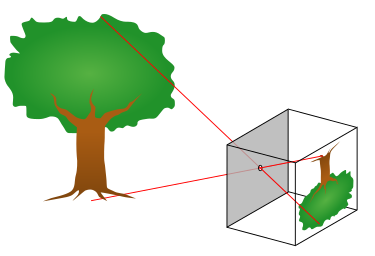
  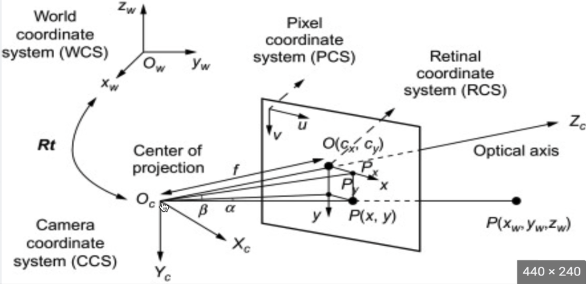
</div>

Some concepts regarding NeRF, such as pinhole camera model, ray tracing, 3D rendering, differentiable rendering, optimization, and rotation matrix. 

The concept of pinhole camera and <a href="https://www.udemy.com/course/neural-radiance-fields-nerf/learn/lecture/35524410#overview">backward ray tracing</a> is that we can replicate the effect by sending **rays from each pixel of the image** (camera) to the scene through the pinhole until the ray hits a light source. 

The right figure reprecents the concept, where $(u,v)$ represent the pixel coordidnate system for the location. The parameters are as following for the camera:
- $H$, $W$ are the resolution of the image.
- $f$ is the distance between the pinhole and the plan where the image is formed at (focal length).
- $u$, $v$ coordinate system representation where $u$ is the change on the x-axis and $v$ is the change on y-axis.

Rays are represented by a vector that can be represented using an origin and a direction. We used the representation $H \times W$ to represent all of the image pixels togather, with 3D view.

When we are computing the directions of the rays in $dirs$ variable, we are starting from the (0,0) coordinates, and going towards the pinhole, thus for example, for the x-axis, we divide the $W$ by 2, then subtract it from the $u$ to reach the center of the image, and thus be centered toward the projection (pinhole). This will result in the center coordinate having a coordinate value of 0 exactly at the center for the x-coordinate.

```python
# debug
u[0][W//2] - W / 2 # where we experiment on the first row of u, and obtain the center coordinate using w//2, and subtract half of the image width, to get the center coordinate value of 0.0
```

Another note regarding the directions is that y-axis is pointing downwards, but we want to use the convention of y pointing upwards, thus we added a negative sign on the y-axis when we were computing the $dirs$ variable. This is similar to the z-axis which is the focal length, that we want it to point from the image towards the pinhole (camera coordinate system), thus we invert it using the negative sign.

In [150]:
# Numpy implementation
H = 400  # Height
W = 400  # Width
f = 1200 # focal length, distance between the pinhole of the box and the plane where the image will be formed on 

# Creating rays, we have two components, each image pixel will have a ray, thus H*W, and 3 for 3D
rays_o = np.zeros((H*W, 3)) # rays origin
rays_d = np.zeros((H*W, 3)) # rays direction

# Computing the coordinates of the pixels
u = np.arange(W)
v = np.arange(H)

# Creating a grid with all possible pixel coord values
# both u and v shapes will transform to H, W, this is because in image processing conventions, it’s always (H, W, …)
u, v = np.meshgrid(u, v)

# Computing the direction that is going from the image to the pinhole (center)
# final shape will be (H, W, 3)
dirs = np.stack(( u - W / 2,           # x-axis (horizontal shift from image center)
                 -(v - H / 2),         # y-axis (vertical shift, flipped so y points up)
                 -np.ones_like(u)*f    # z-axis (into the camera from the image)
                ), axis=-1)            # stack along the last axis, thus stack all three on top of each other, and last axis will be 3

# rays_d.shape is (H, W, 3)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize along the last axis dimension
rays_d = rays_d.reshape(-1, 3) # reshape to (H*W, 3)

print(rays_o.shape, u.shape, v.shape, rays_d.shape, u.shape, v.shape, dirs.shape)

(160000, 3) (400, 400) (400, 400) (160000, 3) (400, 400) (400, 400) (400, 400, 3)


For plotting the rays, we create a function called `plot_rays` that takes the origin, direction, and time $t$ that we want to plot at. Note that matplotlib convension is opposite to what we implemented (that z-axis points positive upwards). Because we are shooting rays in the code in -z direction, matplotlib is showing downwards which is expected.

In [225]:
def plot_rays(o, d, t_max, step=1, sample_points=False):
    """
    Visualize rays and (optionally) sampled points: r(t) = o + t*d
    
    Args:
        o (np.ndarray): shape (N, 3), ray origins.
        d (np.ndarray): shape (N, 3), ray directions (unit).
        t_max (float): maximum distance along ray.
        step (int): subsampling step (>=1).
        sample_points (bool): whether to scatter sample points along each ray.
    """
    assert step >= 1, "`step` must be >= 1"

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection='3d')

    # Endpoints at distance t_max
    pt1 = o
    pt2 = o + t_max * d

    for p1, p2 in zip(pt1[::step], pt2[::step]):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], alpha=0.4)
        
        if sample_points:
            t_vals = np.linspace(0, t_max, num=5)
            pts = p1 + t_vals[:, None] * (p2 - p1)  # shape (5, 3)
            ax.scatter(pts[:,0], pts[:,1], pts[:,2], c="orange", s=5)

        
    ax.scatter(0,0,0, c="red", s=100, label="Camera origin (pinhole)")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("Rays from a Pinhole Camera Model")
    ax.legend()
    # ax.view_init(elev=20, azim=-60)

    plt.show()

In [226]:
rays_o[::400].shape

(400, 3)

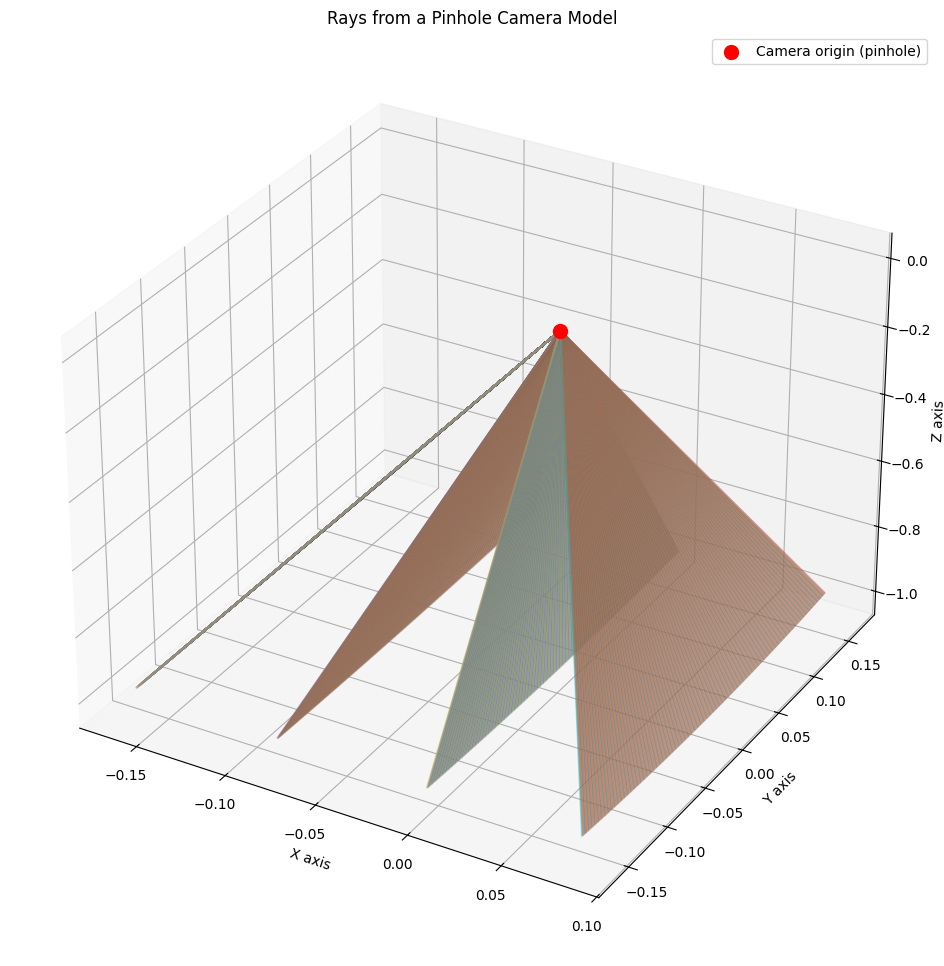

In [228]:
plot_rays(rays_o, rays_d, t_max=1, step=100, sample_points=False)
# plot_rays(rays_o, rays_d, t_max=1, step=590, sample_points=False) # shows the rays better

The next part of the simulator assigns colors to the rays, thus we are able to create an image. The code below creates a simple scene that is represented by a sphere. To assign a color to each ray, we need to know the intersection of the rays with the sphere. The sphere formula can be represented as $(x - xc)^2 + (y - yc)^2 + (z - zc)^2 = r^2$ where $x$, $y$, $z$ are the intersection of the rays with the sphere, therefor we can re-write it as $(ox + t*dx - xc)^2 + (oy + t*dy - yc)^2 + (oz + t*dz - zc)^2 = r^2$. We need to solve this equation to find the time t which the ray hits the sphere. If there is no solution, there won't be t.

First, we will solve the equation $at^{2} + bt + c = 0$, and then solve for $pho = b^{2} - 4 \times a \times c$ to find if there is a solution or not to find $t1$ and $t2$ intersections of the sphere (rays will intersect twice).

In [230]:
class Sphere():
    def __init__(self, p, r, c):
        self.p = p # position
        self.r = r # radius
        self.c = c # color

    def intersect(self, o, d):
        a = d[:, 0]**2 + d[:, 1]**2 + d[:, 2]**2
        b = 2 * ((d[:, 0] * (o[:, 0] - self.p[0])) + (d[:, 1] * (o[:, 1] - self.p[1])) + (d[:, 2] * (o[:, 2] - self.p[2])))
        c = (o[:, 0] - self.p[0])**2 + (o[:, 1] - self.p[1])**2 + (o[:, 2] - self.p[2])**2 - self.r**2

        pho = b**2 - 4* a * c

        condition = pho >= 0

        num_rays = o.shape[0]
        colors = np.zeros((num_rays, 3))
        colors[condition] = self.c # else will be 0
        
        return colors

In [241]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.,]))
c = s.intersect(rays_o, rays_d)
c.sum(), c.shape

(np.float64(45709.0), (160000, 3))

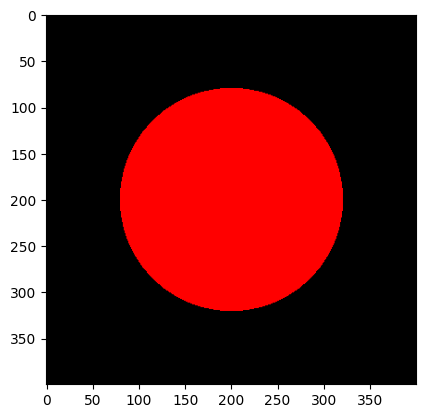

In [242]:
img = c.reshape(H, W, 3)
plt.imshow(img)

Some common ways to represent a scene is using trimesh or volumetric rendering. **NeRF approach utilizes volumetric rendering** rather than trimesh because trimesh is very difficult to be differentiable and to optimize the triangles, thus NeRF relies on volumetric rendering which is easier to optimize. Now, there are new papers that utilizes trimesh. 

In NeRF, each point in space can be represented by both a density and color. Density tells object availability in the space, where an empty space has density equals to 0.

How it works is that a ray is shot towards a scene, where point samples are drawn from the rays. Each point has a color and density, thus if 100 points are used, we will have 100 colors and densities. The ray in the official paper is represented as $r(t) = o + td$ where $t$ is time. The integral in the color formula of the volume rendering is computed from $t_{n}$ to $t_{f}$. We will re-write the `Sphere` class following the volume rendering equation in NeRF paper.

In [259]:
# This is a dummy example to return the colors and densities and will be replaced with the NerF model
class Sphere():
    def __init__(self, p, r, c):
        self.p = p # position
        self.r = r # radius
        self.c = c # color

    def intersect(self, x):
        # x: position x, will have a density and color, need to make sure that the point x is inside the sphere
        # we minus - self.p[0]) to take into account the center of the sphere
        # (x-xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2
        condition = (x[:, 0] - self.p[0])** 2 + (x[:, 1] - self.p[1])** 2 + (x[:, 2] - self.p[2])** 2 <= self.r**2 
        
        num_rays = o.shape[0]
        colors = np.zeros((num_rays, 3))
        density = np.zeros((num_rays, 1))
        
        colors[condition] = self.c # else will be 0
        density[condition] = 10
        
        return colors, density

In [262]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.,]))

In [ ]:
# def rendering(ray_o, ray_d, tn, tf):
    # ray_o, ray_d < rays info
    # tn, tf < integral limits

    # integral equation here
    

#### Dataset

In [174]:
np.outer(1, 200)

array([[200]])

In [94]:
[1,2,3,4,5,6,7,8,9,10][::1]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
if not os.path.isdir('./data/nerf_example_data'):
    os.makedirs('./data/nerf_example_data')

data_url = 'http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip'
filename = './data/nerf_example_data/nerf_example_data.zip'

urllib.request.urlretrieve(data_url, filename)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./data/nerf_example_data')

In [17]:
os.listdir('./data/nerf_example_data')

['nerf_example_data.zip', 'nerf_llff_data', 'nerf_synthetic']

In [21]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

trans_t(9)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 9.],
        [0., 0., 0., 1.]])

In [23]:
import os
import torch
import numpy as np
import imageio 
import json
import torch.nn.functional as F
import cv2

trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w


def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    counts = [0]
    for s in splits:
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1
        else:
            skip = testskip
            
        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame['transform_matrix']))
        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0])
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    
    render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    
    if half_res:
        H = H//2
        W = W//2
        focal = focal/2.

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res
        # imgs = tf.image.resize_area(imgs, [400, 400]).numpy()

        
    return imgs, poses, render_poses, [H, W, focal], i_split

In [29]:
imgs, poses, render_poses, [H, W, focal], i_split = load_blender_data('./data/nerf_example_data/nerf_synthetic/lego', True, 8)

/tmp/ipykernel_5670/1672725086.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


In [45]:
print(imgs.shape)
print(poses.shape)
print(render_poses.shape)
print(H)
print(W)
print(focal)
print(i_split)

'''
images → RGB training data.
poses → camera extrinsics (where the camera was).
render_poses → synthetic test path for rendering videos.
H, W → image resolution.
focal → camera intrinsics (for ray projection).
i_split → train/val/test index splits.
'''

(138, 400, 400, 4)
(138, 4, 4)
torch.Size([40, 4, 4])
400
400
555.5555155968841
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]), array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])]


In [47]:
poses[0]

array([[-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
       [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
       [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

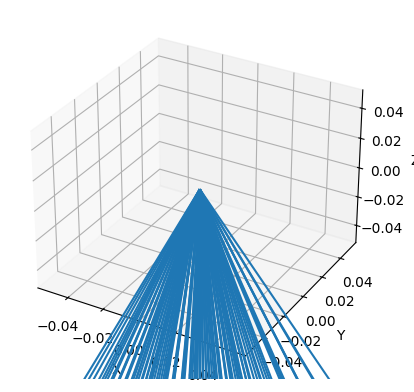

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def get_rays(H, W, focal, c2w):
    # Create meshgrid of pixel coordinates
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    
    # Directions in camera coordinates
    dirs = np.stack([(j - W * 0.5) / focal,
                     -(i - H * 0.5) / focal,
                     -np.ones_like(i)], axis=-1)  # shape: (H, W, 3)
    
    # Rotate ray directions to world coords
    rays_d = dirs @ c2w[:3,:3].T  # (H, W, 3)
    rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
    
    # Origin is the same for all pixels in this image
    rays_o = np.broadcast_to(c2w[:3, 3], rays_d.shape)  # (H, W, 3)
    
    return rays_o, rays_d


# H, W, focal = 400, 400, 555.0   # Example values
c2w = np.eye(4)  # Identity = camera at origin looking along -z

rays_o, rays_d = get_rays(H, W, focal, c2w)

# Pick a subset of pixels (e.g., every 40th)
step = 40
subset_o = rays_o[::step, ::step]
subset_d = rays_d[::step, ::step]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(subset_o[...,0], subset_o[...,1], subset_o[...,2],
          subset_d[...,0], subset_d[...,1], subset_d[...,2], length=0.5, normalize=True)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


#### List of Variables

| Variable  | Shape  | Description  |
|-----------|--------|--------------|
|           |        |              |
|           |        |              |
|           |        |              |

#### Positional Encoding

#### Hierarchical Volume Sampling

#### Notes

* Nerf-- (Without Camera Params) YT paper walkthrough: https://www.youtube.com/watch?v=Cf63bTpbt0s
* https://www.reddit.com/r/MachineLearning/comments/sm9li0/p_minimal_pytorch_implementation_of_nerf_full/
* https://docs.nerf.studio/nerfology/model_components/visualize_samples.html
* https://www.udemy.com/course/neural-radiance-fields-nerf/?referralCode=DD33817D57404AF048DF
* https://www.youtube.com/watch?v=CRlN-cYFxTk

#### Todos

* Siren vs NeRF?